# Hierarchical clustering on the Car dataset with Passively Obtained Quadruplets

The Car dataset is a comparison-based dataset composed of 60 different cars. Here, we show how we can use ComparisonHC to learn a dendrogram of the cars.

## Imports
We start by importing the ComparisonHC class, the core of the method.

In [1]:
from comparisonhc import ComparisonHC

Then we choose an oracle from the module oracle. Here, we settle for an oracle that directly uses the comparisons provided by the dataset.

In [2]:
from comparisonhc.oracle import OracleComparisons

We also need to choose the linkage used by ComparisonHC. Here, we choose the average linkage that directly uses comparisons (4-AL in the reference paper). 

In [3]:
from comparisonhc.linkage import OrdinalLinkageAverage

Finally we import numpy for array manipulations and several packages used to visualize the result.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage,AnnotationBbox
from scipy.cluster.hierarchy import dendrogram
from PIL import Image

## The Car Dataset

The Car dataset contains 60 cars and comes with 6056 ordinal comparisons, collected via crowd-sourcing, of the form ``Which car is most central amongthe three i, j and k?''. These comparisons can be converted to quadruplets as explained in the paper.

In [5]:
triplets = np.genfromtxt( "../resources/car/ordinal_data_preprocessed/T_ALL_REDUCED.csv", delimiter=',',dtype='int8')
    
n = np.amax(triplets)
    
quadruplets = np.zeros((n,n,n,n))
for triplet in triplets:
    quadruplets[triplet[1]-1,triplet[0]-1,triplet[1]-1,triplet[2]-1] = 1
    quadruplets[triplet[0]-1,triplet[1]-1,triplet[1]-1,triplet[2]-1] = 1
    quadruplets[triplet[1]-1,triplet[0]-1,triplet[2]-1,triplet[1]-1] = 1
    quadruplets[triplet[0]-1,triplet[1]-1,triplet[2]-1,triplet[1]-1] = 1
        
    quadruplets[triplet[1]-1,triplet[2]-1,triplet[1]-1,triplet[0]-1] = -1
    quadruplets[triplet[2]-1,triplet[1]-1,triplet[1]-1,triplet[0]-1] = -1
    quadruplets[triplet[1]-1,triplet[2]-1,triplet[0]-1,triplet[1]-1] = -1
    quadruplets[triplet[2]-1,triplet[1]-1,triplet[0]-1,triplet[1]-1] = -1
        
    quadruplets[triplet[2]-1,triplet[0]-1,triplet[2]-1,triplet[1]-1] = 1
    quadruplets[triplet[0]-1,triplet[2]-1,triplet[2]-1,triplet[1]-1] = 1
    quadruplets[triplet[2]-1,triplet[0]-1,triplet[1]-1,triplet[2]-1] = 1
    quadruplets[triplet[0]-1,triplet[2]-1,triplet[1]-1,triplet[2]-1] = 1
        
    quadruplets[triplet[2]-1,triplet[1]-1,triplet[2]-1,triplet[0]-1] = -1
    quadruplets[triplet[1]-1,triplet[2]-1,triplet[2]-1,triplet[0]-1] = -1
    quadruplets[triplet[2]-1,triplet[1]-1,triplet[0]-1,triplet[2]-1] = -1
    quadruplets[triplet[1]-1,triplet[2]-1,triplet[0]-1,triplet[2]-1] = -1

## Initializing ComparisonHC

### Oracle

To initialize ComparisonHC we start by creating an oracle exhibiting three methods to access the quadruplets, comparisons, comparisons_to_ref, and comparisons_single. Here we chose a passive oracle that directly works with the comparisons.

In [6]:
oracle = OracleComparisons(quadruplets)

### Linkage

We also need to create the linkage object that will be used to merge the clusters. This object exhibits a single method called closest_clusters that can be used to choose which clusters to merge next. We use an average linkage using only comparisons.

In [7]:
linkage = OrdinalLinkageAverage(oracle)

### ComparisonHC

We can now create the main ComparisonHC object using the linkage defined above.

In [8]:
chc = ComparisonHC(linkage)

## Learning the Dendrogram

To learn a dendrogram we need to use the fit method from ComparisonHC with initial clusters. Here, we start with one example per cluster.

In [9]:
chc.fit([[i] for i in range(n)])

print("ComparisonHC ran for {:.2f} seconds.".format(chc.time_elapsed))

ComparisonHC ran for 1.91 seconds.


## Plotting the Dendrogram

Since we do not have access to a ground truth similarity nor a ground truth dendrogram, quantitatively evaluating the performance of the method is difficult. Instead, we propose to directly visualize the learned dendrogram.

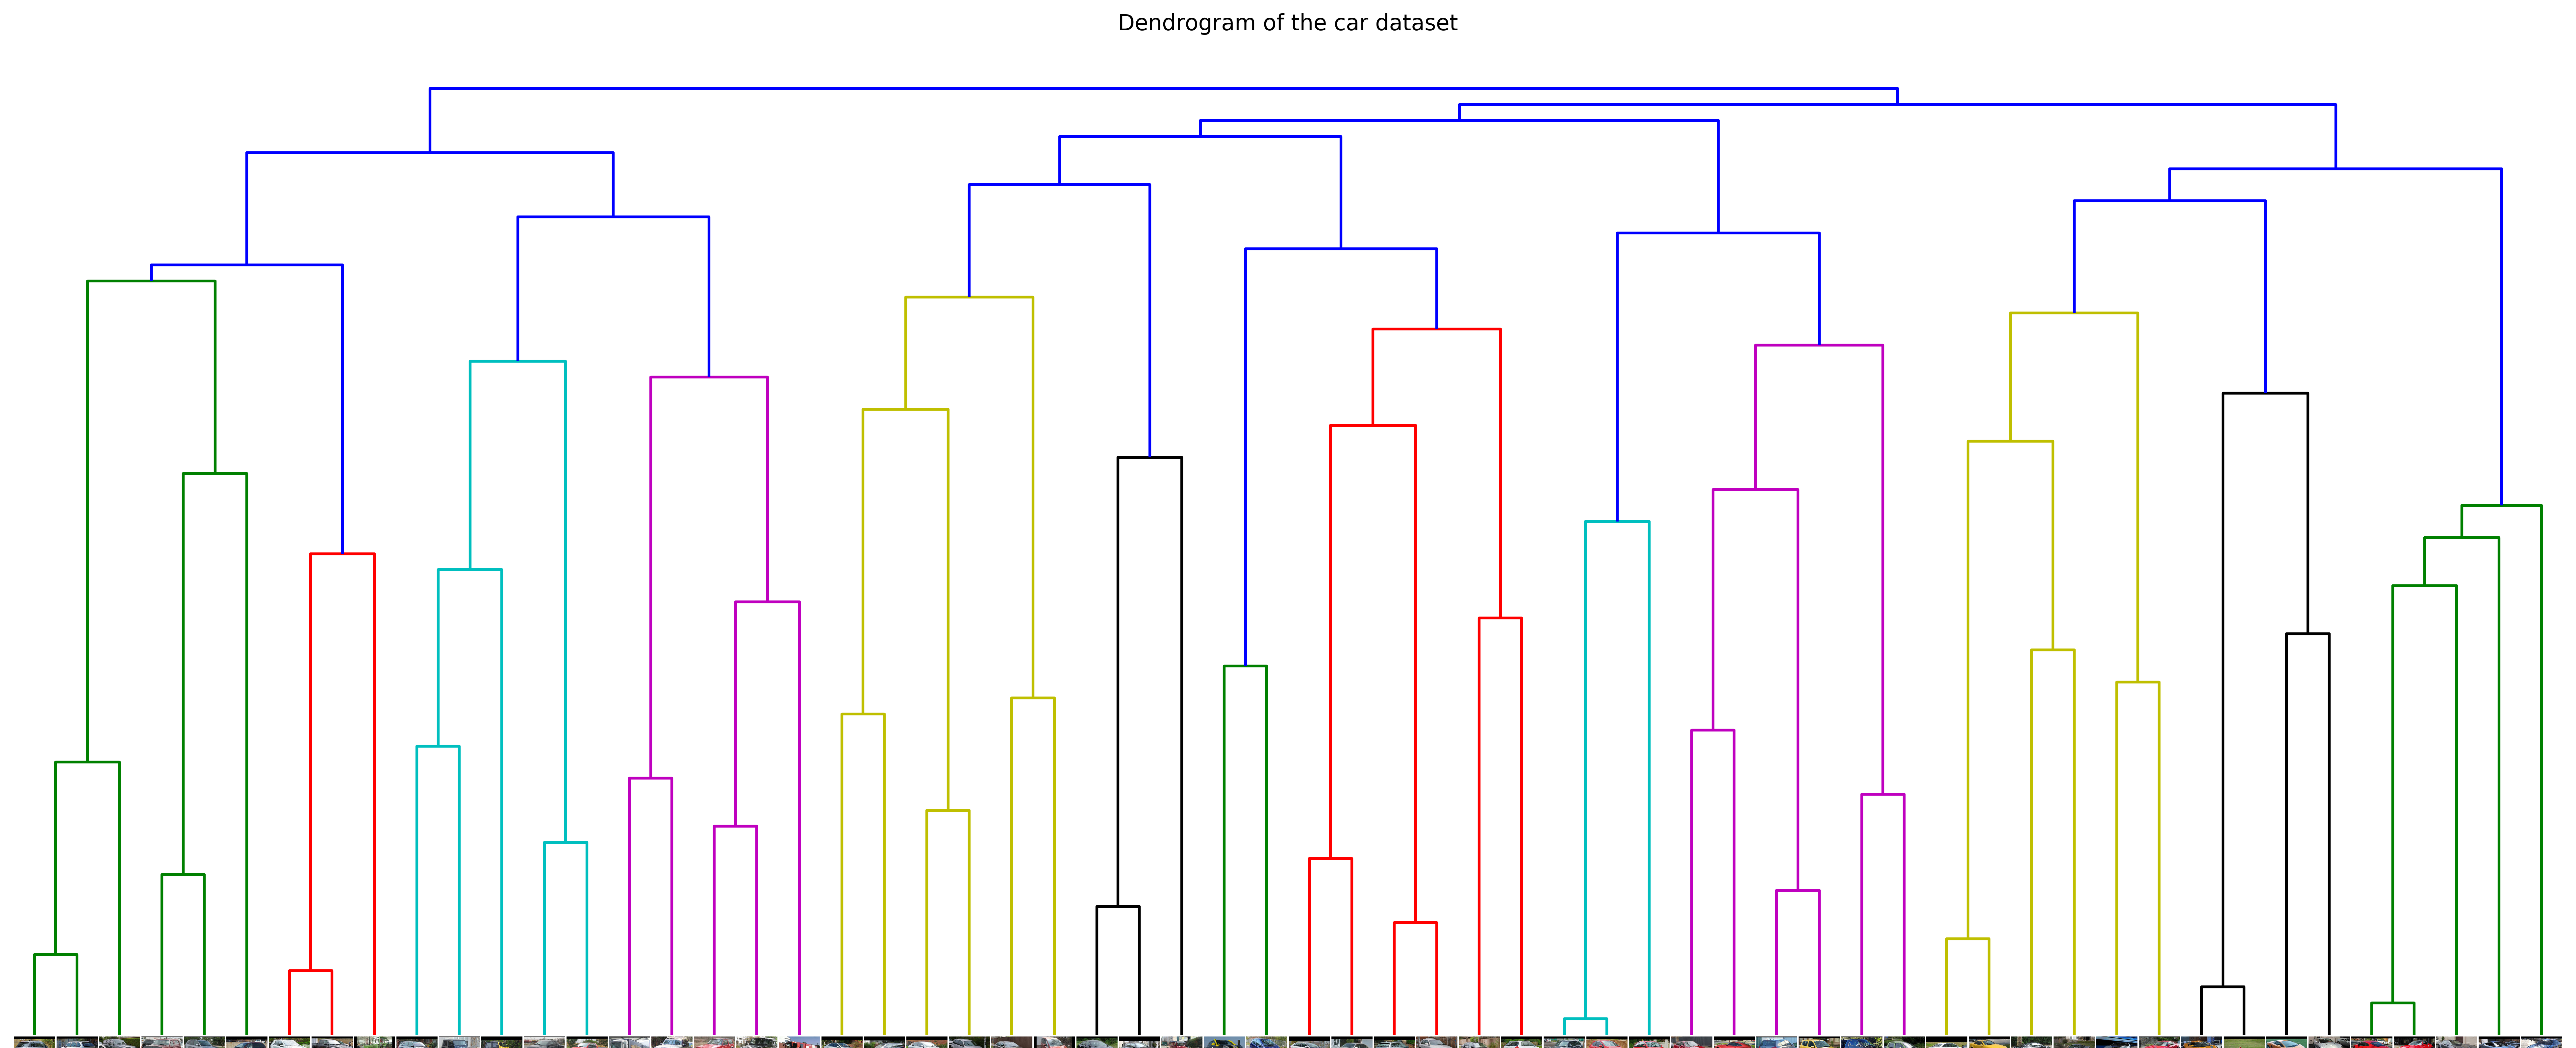

In [10]:
x_s = 25
y_s = 10
dpi = 400
fig = plt.figure(figsize=(x_s, y_s),dpi=dpi)
plt.title("Dendrogram of the car dataset")

# Folder containg the car images
images_folder = "../resources/car/car_data_set_images/"
images_extension = "jpg"
# Name of each images
names = [str(i+1) for i in range(n)]

# Convert to scipy format
dendrogram_scipy = np.zeros((n-1,4))
dendrogram_scipy[:,0] = chc.dendrogram[:,0]
dendrogram_scipy[:,1] = chc.dendrogram[:,1]
dendrogram_scipy[:,2] = np.arange(n-1)+1
dendrogram_scipy[:,3] = chc.dendrogram[:,2]

# Initial plot
dendrogram(dendrogram_scipy,labels=names,leaf_rotation=90.,leaf_font_size=8.,color_threshold=(0.8*max(dendrogram_scipy[:,2])))
    
# Add the images of the cars
ax = plt.gca()
    
xlbls_locs = ax.get_xaxis().get_majorticklocs()
    
xlbls = ax.get_xmajorticklabels()
extra_artists = []
for loc,lbl in zip(xlbls_locs,xlbls):
    image_path = images_folder+"/"+lbl.get_text()+"."+images_extension
        
    im = Image.open(image_path)

    ratio = ((dpi*x_s/n))/im.size[0]
    correct_size = (im.size[0]*ratio, im.size[1]*ratio)
    im.thumbnail(correct_size, Image.ANTIALIAS)

    imagebox = OffsetImage(im, zoom=0.135)
    imagebox.image.axes = ax

    ab = AnnotationBbox(imagebox, (loc,0),xybox=(0, -1),xycoords=("data", "axes fraction"),boxcoords="offset points",box_alignment=(.5, 1),bboxprops={"edgecolor" : "none"},pad = 0)
    ax.add_artist(ab)
    extra_artists.append(ab)
ax.axison = False

plt.show()